<div class = "alert alert-block alert-info">
    
__Регрессия__
    
В общем то как я и говорил делаешь то же самое что и для тестового задания: регрессию по концентрации для каждой из солей. Любым методом, какой больше нравится / лучше работает.
Метрики те же : MAE, RMSE, $R^2$

Единственное что для нормальной оценки, нужно делать проверку не на отложенной выборке с помощью `train_test_split`, а по кросс-валидации. 
    
А именно, для поиска гиперпараметров есть функция `GridSearchCV`. Документация у `sklearn` довольно понятная, а потому искренне советую туда заглянуть.
</div>

In [32]:
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns    

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score


SO4_DF = pd.read_csv('../../data/interim/SO4_12_11.csv')
SO4_DF['concentration'] = np.arange(0.056, 5.760 ,0.056)
SO4_DF = SO4_DF.drop(['Id', 'CreationStamp', 'Dataset', 'Description'], axis=1)
SO4_DF = SO4_DF.dropna()
SO4_DF.head()

,Ch_0_0,Ch_0_1,Ch_0_2,Ch_0_3,Ch_0_4,Ch_0_5,Ch_0_6,Ch_0_7,Ch_0_8,Ch_0_9,...,Ch_1_9,Ch_1_10,Ch_1_11,Ch_1_12,Ch_1_13,Ch_1_14,Ch_1_15,Ch_1_16,Ch_1_17,concentration
0,202.8853,452.4438,2376.484,12762.95,5818.188,13608.69,929.2092,3125.965,3074.175,597.4990,...,919.9712,1103.201,943.3545,655.9867,773.5270,199.9196,321.0435,185.8763,227.7228,0.056
1,200.0278,427.6784,2347.133,12186.34,5753.003,13913.87,891.1827,3152.291,3037.146,602.5483,...,922.4666,1085.731,904.9215,604.4929,600.0151,201.2220,293.0418,185.8763,209.2325,0.112
2,197.1702,421.0108,2296.952,12360.56,5575.228,15844.71,949.6849,3190.317,3104.470,611.8053,...,919.9712,1175.699,942.4810,658.2256,829.4985,200.5708,293.0418,180.0372,240.3740,0.168
3,210.5054,438.1561,2367.962,12773.36,5546.586,16656.55,1003.3120,3253.695,3160.854,618.5377,...,943.2616,1175.699,960.8240,667.1810,789.1990,198.6172,319.7411,181.9836,228.6959,0.224
4,223.8406,486.7343,2304.526,13378.37,5037.952,14415.59,952.6100,3181.542,2968.139,580.6680,...,931.6164,1119.797,921.5176,681.7336,876.5146,188.1979,292.3906,182.9568,245.2399,0.280


In [34]:
weights = {
        'LinearRegression': lambda mod: mod.coef_,
        'RandomForestRegressor': lambda mod: mod.feature_importances_,
        'SVR': lambda mod: mod.coef_[0],
        'PLSRegression': lambda mod: [o[-1] for o in mod.x_weights_],
}

In [83]:
def crosFit(df, models):
    #df = df.rename(columns={'target': 'true'})
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    ans = {
        'models' : [],
        'data': {
            'X_test': X,
            'y_test': y,
            'chanels': [i for i in range(1, len(df.columns[:-1])+1)],
        }
    }
    
    for model in models:
        predictions = []
        loo = LeaveOneOut()
        
        for train_inds, test_inds in loo.split(X, y):
            X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y.iloc[train_inds], y.iloc[test_inds]
            model.fit(X_train, y_train) 

            predict = model.predict(X_test)
            predictions.append(predict[0])

        m = str(model)
        name = m[:m.index('(')]
        if name == 'PLSRegression':
            pred = pd.DataFrame({'prediction':[t[0] for t in predictions]})
        else:
            pred = pd.DataFrame({'prediction': predictions})
        ans['models'].append({
            'name': name,
            'predict': pred,
            'R2': r2_score(y, predictions),
            'RMSE': np.sqrt(mean_squared_error(y, predictions)),
            'x_weights': weights[name](model),
        })
    return ans

In [84]:
def describe(data, nam=''):
    X_test = data['data']['X_test']
    y_test = data['data']['y_test']
    
    dat = pd.DataFrame({'chanels': data['data']['chanels']})
    
    for obj in data['models']:
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
        
        d = pd.DataFrame({'$y_{true} - y_{predict}$':  y_test - obj['predict']['prediction']})
        sns.histplot(data=d, x='$y_{true} - y_{predict}$', kde=True, stat='probability', ax=ax[0])

        sns.regplot(x=obj['predict'], y=y_test, label='True - Prediction', ax=ax[1])
        text = "$R^2 = {0:4.4f}$\n$RMSE = {1:4.4f}$".format(obj['R2'], obj['RMSE'])
        ax[1].legend(labels=['True-Predict'], title=text)
        ax[1].grid(1)
        
        dat['weights'] = obj['x_weights']
        sns.scatterplot(data=dat, x='chanels', y='weights', ax=ax[2])
        ax[2].grid(1)
        
        plt.suptitle(nam + " " + obj['name'])
        plt.show()

In [79]:
models = [
    #LinearRegression(), # метод наименьших квадратов
    RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # случайный лес
    #SVR(kernel='linear'), # метод опорных векторов с линейным ядром
    PLSRegression(n_components=2) # PLS
]

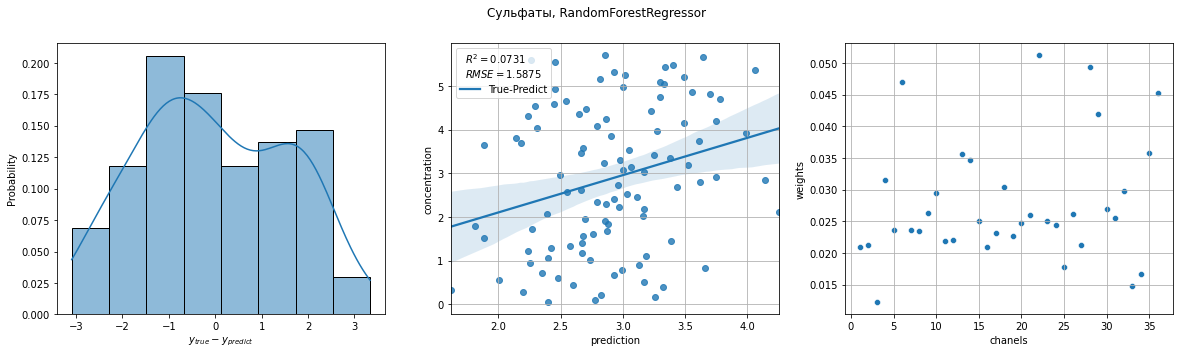

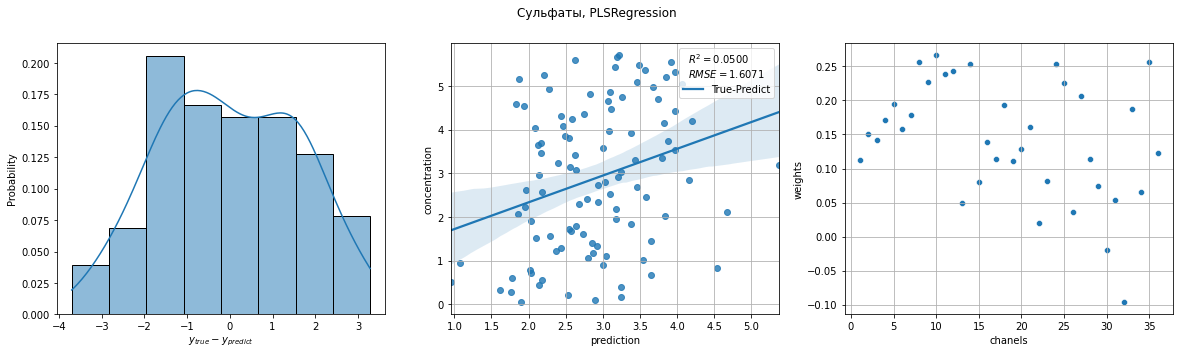

In [80]:
r = crosFit(SO4_DF, models)
describe(r, 'Сульфаты,')

In [81]:
CL_DF = pd.read_csv('../../data/interim/CL_12_11.csv')
CL_DF['concentration'] = np.arange(0.050, 5.01 ,0.050)
CL_DF = CL_DF.drop(['Id', 'CreationStamp', 'Dataset', 'Description'], axis=1)
CL_DF = CL_DF.dropna()
CL_DF.head()

,Ch_0_0,Ch_0_1,Ch_0_2,Ch_0_3,Ch_0_4,Ch_0_5,Ch_0_6,Ch_0_7,Ch_0_8,Ch_0_9,...,Ch_1_9,Ch_1_10,Ch_1_11,Ch_1_12,Ch_1_13,Ch_1_14,Ch_1_15,Ch_1_16,Ch_1_17,concentration
0,219.0780,481.9717,2410.569,13455.06,5688.807,14208.19,947.7349,3232.244,3042.196,597.4990,...,932.4482,1166.091,962.5710,681.7336,837.3346,202.5244,337.3236,180.0372,229.6691,0.05
1,219.0780,437.2036,2309.260,12266.82,5456.711,16397.79,976.0109,3192.267,2983.287,589.0836,...,895.0172,1125.911,911.0359,658.2256,734.3469,188.8491,278.7153,175.1714,207.2861,0.10
2,227.6507,492.4493,2388.792,13749.52,5103.136,14153.87,928.2341,3189.342,2990.020,586.5589,...,944.9252,1128.531,943.3545,698.5251,889.9479,188.8491,309.9731,180.0372,246.2131,0.15
3,206.6954,436.2511,2280.856,12816.92,5310.541,16036.31,988.6863,3258.570,3106.153,626.1116,...,931.6164,1146.875,949.4688,651.5090,838.4540,200.5708,308.6707,183.9299,253.9985,0.20
4,212.4104,427.6784,2241.090,12097.34,5308.565,16381.99,982.8361,3181.542,2972.347,594.9744,...,915.8122,1133.772,937.2402,663.8228,783.6019,197.9660,313.8803,181.9836,225.7764,0.25


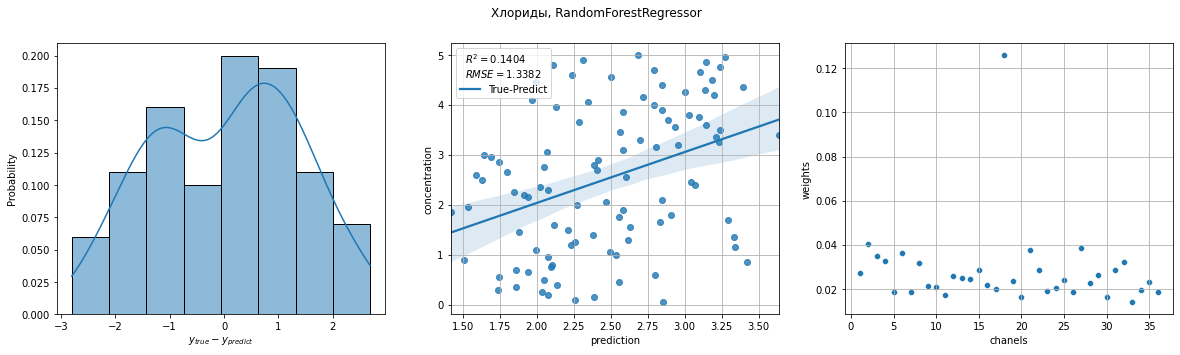

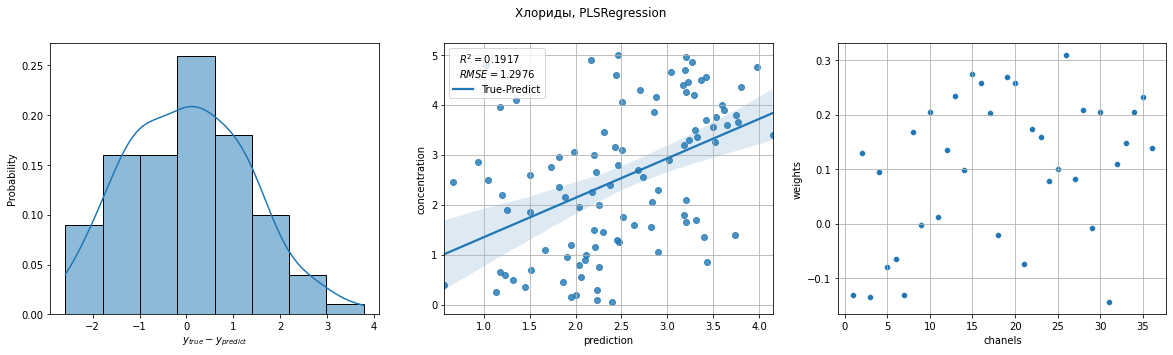

In [82]:
r = crosFit(CL_DF, models)
describe(r, 'Хлориды,')

In [94]:
from sklearn.model_selection import ParameterGrid
mod = RandomForestRegressor()

params = ParameterGrid({'n_estimators': '100', 'max_features': 'sqrt'})
list(params)

[{'max_features': 's', 'n_estimators': '1'},
 {'max_features': 's', 'n_estimators': '0'},
 {'max_features': 's', 'n_estimators': '0'},
 {'max_features': 'q', 'n_estimators': '1'},
 {'max_features': 'q', 'n_estimators': '0'},
 {'max_features': 'q', 'n_estimators': '0'},
 {'max_features': 'r', 'n_estimators': '1'},
 {'max_features': 'r', 'n_estimators': '0'},
 {'max_features': 'r', 'n_estimators': '0'},
 {'max_features': 't', 'n_estimators': '1'},
 {'max_features': 't', 'n_estimators': '0'},
 {'max_features': 't', 'n_estimators': '0'}]

In [95]:
clf = GridSearchCV(mod, params)
clf.fit(CL_DF.iloc[:, :-1], CL_DF.iloc[:, -1])

ValueError: Parameter grid for parameter (max_features) needs to be a list or numpy array, but got (<class 'str'>). Single values need to be wrapped in a list with one element.

<div class = "alert alert-block alert-info">
    
__Классификация__
   
Сначала нужно привести эту задачу к задаче классификации: ввести пороговое значение, все концентрации что ниже порога получают метку "0", все что выше - метку "1".
    
А дальше подбор параметров на кросс-валидации, со стратификацией по таргету, так же чтобы количество единичек и нулей на тесте и трейне было одинаковым
    
Метрики качества : precision, recall, f1-score, ROC-AUC (последнее использовать только если у тебя порог по концетрации не такой, что слишком мало или слишком много какого то из классов (из-за большого дисбаланса классов метрика ведет себя не очень адекватно)). Лучше всего первые три показать после подбора гиперпараметров с помощью `classification_report`:
</div>

__Пример__

In [5]:
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [20]:
# Эта штука генерирует набор объектов и меток
# Типа "модельная" классификация
X, y = make_classification(n_samples=1000)
Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
clf = LogisticRegression()
clf.fit(Train_X, Train_y)

# Обрати внимание что есть "probs" а есть "preds"
# "probs" - это вероятности принадлежности классу
# "preds" - непосредственно метки класса
# У тебя "probs" - это значения функции сигмоиды от выхода PLS модели (для мочи)
# а "preds" - это то что после отсечения по threshold

probs = clf.predict_proba(Test_X)[:,1]
preds = clf.predict(Test_X)

In [19]:
# Также обрати внимание что в roc_auc_score передается именно вероятности probs
print(f"ROC-AUC: {roc_auc_score(Test_y, probs):.3f}")
print(classification_report(Test_y, preds))

ROC-AUC: 0.965
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       102
           1       0.96      0.87      0.91        98

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200



<div class = "alert alert-block alert-info">
    
Делаешь то же самое только на кросс-валидации
    
</div>

<div class = "alert alert-block alert-info">
    
Для адекватного использования этого вместе с `GridSearchCV` есть штука `pipeline`. Также рекомендую посмотреть примеры использования в документации
    
</div>

In [2]:
from sklearn.pipeline import make_pipeline